##**Natural Language Processing - A.Y. 2021/2022** 
#**Course Project - Humor detection in Tweets: baselines vs BERT**
Jan Elefes (2040496) , Giovanna Pilot (2062883) 

## Introduction and presentation of the Task

Humor is a complex sociological phenomenon and plays an essential role in human relationships.  It helps soften tense moments, cheers us up, and makes our lives more pleasant and light.\
In machine learning, there is very little work done on humor detection probably due to the complexity of the task. Being able to automatically recognize humor could improve a lot human-centered artificial intelligence systems such as chatbots and virtual assistants.\
Our work aims to tell whether a tweet is sarcastic and to do so we use different versions of BERT comparing them with baseline models such as logistic regression, SVM, random forest and an LSTM. 


**BERT**

BERT is a model designed specifically for NLP tasks and it involves a multi-layer bidirectional transformer encoder.  Unlike other methods such as LSTM which processes a sentence from left to right one word at a time, BERT simultaneously processes all the words in the sentence. Since BERT was introduced in the NLP world, many other versions of it were released such as Multilingual BERT, RoBERTa, BERTweet and many others.


### **Dataset**
In this work, we use a dataset from the SemEval 2022 composed of 3467 tweets written in English. The dataset lies within a larger project which aims to detect sarcasm both in English and Arabic [source](https://sites.google.com/view/semeval2022-isarcasmeval#h.t53li2ejhrh8). For the English part of the dataset, each tweet is attached with: 
* a label specifying its sarcastic nature (sarcastic or non-sarcastic), provided by its author;
* a rephrase provided by its author that conveys the same message non-sarcastically; 
* a label specifying the category of ironic speech that it reflects, provided by a linguistic expert.

For what concerns our task we only keep the dummy variable which specifies whether the text is sarcastic. The dataset contains 25% of sarcastic tweets and the majority of sarcastic and non-sarcastic tweets are shorter than 30 words. 

In [ ]:
import torch
import tensorflow as tf
import transformers
from transformers import AutoModel
from collections import defaultdict
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from ekphrasis.classes.segmenter import Segmenter
from textblob import TextBlob
import contractions
import string
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

#set the random seed for further operations
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 51.9 MB/s 
     |████████████████████████████████| 596 kB 54.7 MB/s 
     |████████████████████████████████| 101 kB 6.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 5.1 MB/s 
     |████████████████████████████████| 90 kB 8.9 MB/s 
     |████████████████████████████████| 132 kB 53.9 MB/s 
     |████████████████████████████████| 79 kB 10.2 MB/s 
     |████████████████████████████████| 8.9 MB 66.1 MB/s 
     |████████████████████████████████| 138 kB 72.3 MB/s 
     |████████████████████████████████| 127 kB 74.8 MB/s 
  Attempting uninstal

In [ ]:
# look for GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# assign gpu to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Found GPU at: /device:GPU:0


'Tesla T4'

In [ ]:
#we loead the dataset and delate rows with Nan values
df = pd.read_csv('train.En.csv')
# df=df[['tweet', 'sarcastic']]
df=df.dropna()

# have a look at some examples
print(df.head())
print(df.info())

   Unnamed: 0                                              tweet  sarcastic  \
0           0  The only thing I got from college is a caffein...          1   
1           1  I love it when professors draw a big question ...          1   
2           2  Remember the hundred emails from companies whe...          1   
3           3  Today my pop-pop told me I was not “forced” to...          1   
4           4  @VolphanCarol @littlewhitty @mysticalmanatee I...          1   

                                            rephrase  sarcasm  irony  satire  \
0  College is really difficult, expensive, tiring...      0.0    1.0     0.0   
1  I do not like when professors don’t write out ...      1.0    0.0     0.0   
2  I, at the bare minimum, wish companies actuall...      0.0    1.0     0.0   
3  Today my pop-pop told me I was not "forced" to...      1.0    0.0     0.0   
4  I would say Ted Cruz is an asshole and doesn’t...      1.0    0.0     0.0   

   understatement  overstatement  rhetorical

In [ ]:
df

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
862,862,yo @claires do yall do hysterectomies?,1,"Claires, you should not do full hysterectomies.",1.0,0.0,0.0,0.0,0.0,1.0
863,863,@JacobWohlReport Do I need to aquire a wife be...,1,A lot of people don't have a wife.,1.0,0.0,0.0,0.0,0.0,1.0
864,864,I get a lot of boy who cried wolf vibes from t...,1,The red cross is always needy.,0.0,1.0,0.0,0.0,0.0,0.0
865,865,Update: holding hands with your mom and walkin...,1,Holding hands with your parent while walking a...,1.0,0.0,0.0,0.0,0.0,0.0


Percentage of Sarcastic Tweets: 0.25


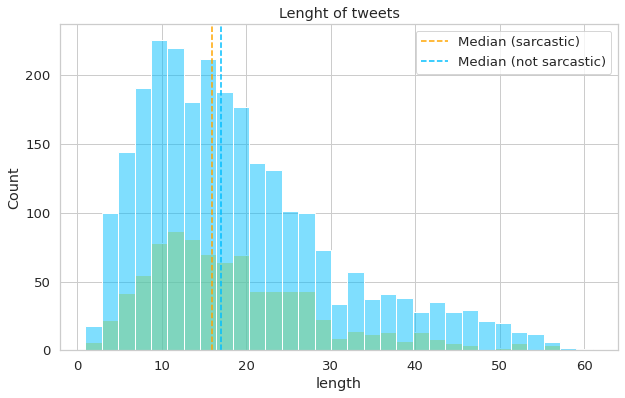

In [ ]:
#print the pertcentage of sarcastic tweet in the dataset 
print(f'Percentage of Sarcastic Tweets: {np.round(df.sarcastic.mean(), 2)}')

# calculate tweet lengths
df['length'] = [len(str(t).split()) for t in df.tweet.values]

# plot length distribution
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 10, 6
sns.histplot(x='length', hue='sarcastic', data=df)
plt.axvline(df[df.sarcastic==1].length.median(), c='orange', linestyle='--', label='Median (sarcastic)')
plt.axvline(df[df.sarcastic==0].length.median(), linestyle='--', label='Median (not sarcastic)')
plt.legend()
plt.title('Lenght of tweets')
plt.show()

## Preprocessing

Before the modelling phase, we perform some pre-processing tasks.

First, since we are dealing with tweets, we eliminate hashtags and segment the words within the hashtag because most of the time they are constructed of multiple words.

Using the library TextBlob we check and correct the spelling of the tweets. Tweets are usually quickly written texts and can contain many spelling mistakes that could mislead the model.

Later, we substitute the contracted forms with their full form. Examples are verbs such as isn’t that is transformed to is not and can’t to can not. We then eliminate punctuation, links, emails and emojis.

BERT expects input data in a specific format, with special tokens so we add [CLS] to mark the beginning and [SEP] at the separation/end of sentences. Furthermore, we tokenize our text into tokens that correspond to BERT’s vocabulary.

After the tokenization, we assign to each token a sequence of integers that maps each input token to its index number in the BERT tokenizer vocabulary. Moreover, BERT requires that each input sentence is the same length, so we decide to set the maximum length of our inputs to 40 since we have seen in the distribution graph that most of the tweets are shorter or equal to 40.
We apply the pad function that shortens or lengthens the sentence in order to reach the set maximum length. 

We define the attention mask that we will use in BERT and in the end we split the dataset into train, validation and test set. 

In [ ]:
# splitting hashtags
seg_tw = Segmenter(corpus="twitter")
collection = []

def segmentation(word):
  if "#" in word:
    word=word.replace('#','')
    word=seg_tw.segment(word)
  elif "@" in word:
    word=word.replace('@','')
    word=seg_tw.segment(word)
  return word

for tweet in df.tweet:
  segmented_words= [segmentation(word) for word in tweet.split()]
  segmented_text = ' '.join(segmented_words)
  collection.append(segmented_text)

df.loc[:,"tweet"] = collection

Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [ ]:
# correct spelling mistakes
new_text = df.loc[:,"tweet"].copy()
collection=[]
for text in new_text: 
  textBlb = TextBlob(text)          
  textCorrected = textBlb.correct() 
  collection.append(textCorrected) 

 
df.loc[:,"tweet"] = collection

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


In [ ]:
# eliminate contractions
collection = []   
for tweet in df.tweet:
  expanded_words= [contractions.fix(word) for word in tweet.split()]
  expanded_text = ' '.join(expanded_words)
  collection.append(expanded_text)

df.loc[:,"tweet"] = collection

In [ ]:
# eliminate punctiation
string.punctuation
for tweet in df.tweet:
  punctuationfree="".join([i for i in tweet if i not in string.punctuation])

In [ ]:
# eliminate emailadresses, emojis, ...
collection = [] 
new_text = df.loc[:,"tweet"].copy()
for text in new_text: 
  #replace email addresses with "emailaddress"
    text = text.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

  #replace web addresses with "webaddress"
    text = text.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    #eliminate emojis
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    #eliminate all symbols 
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    collection.append(text)

df.loc[:,"tweet"] = collection

In [ ]:
# adding tokens required by bert 
collection=[]

new_text = df.loc[:,"tweet"].copy()
for text in new_text:
  text = "[CLS] " + text + " [SEP]"
  collection.append(text)

df.loc[:,"tweet"] = collection
print(df.head())

                                               tweet  sarcastic  length
0  [CLS] The only thing I got from college is a c...          1      11
1  [CLS] I love it when professors draw a big que...          1      26
2  [CLS] Remember the hundred email from companie...          1      36
3  [CLS] Today my poppop told me I was not “force...          1      17
4  [CLS] orphan carl little witty mystical manage...          1      29


In [ ]:
# tokenization
sentences = df.tweet.values
labels = df.sarcastic.values

# tokenize the tweets using tokenizer from Bert using the bert-large-cased pre-trained model 
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

The pre-trained model you are loading is a cased model but you have not set `do_lower_case` to False. We are setting `do_lower_case=False` for you but you may want to check this behavior.
100%|██████████| 213450/213450 [00:00<00:00, 22051631.54B/s]


In [ ]:
MAX_LEN = 40
#padding the sentences to make them the same length 
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
# split train, validation and test sets
train_val_inputs, test_inputs, train_val_labels, test_labels = train_test_split(input_ids, labels, train_size = 0.8, random_state=42, shuffle=True) 
train_val_masks, test_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=42, shuffle=True, train_size=0.8)


train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_val_inputs, train_val_labels, 
                                                                                    train_size = 0.9, random_state=42, shuffle=True) 
train_masks, validation_masks, _, _ = train_test_split(train_val_masks, train_val_inputs,
                                             random_state=42, shuffle=True, train_size=0.9)


## Baseline models

In the following we will test 4 baslines. 3 of those (Logsitic Regression, SVM and Random Forest) are general classifiers. These should give us an orientation on what is possible with the data without using any spcialized methods. The fourth model is an LSTM. With that, we try a model that is more suited for the task of dealing with sequences in particular. Though, it is still much smaller in terms of parameters than BERT or variants of it.

#### Logistic Regression

In [ ]:
# define grid search parameters 
logreg_params = {
    'C': [0.5, 1, 5, 10, 100, 500],
}

clf = LogisticRegression(random_state=42, max_iter=1000)
clf_grid_logreg = GridSearchCV(estimator=clf, param_grid=logreg_params, cv = 5, n_jobs=-1)
clf_grid_logreg.fit(train_inputs, train_labels) 

# check the f1 score
train_pred = clf_grid_logreg.predict(train_inputs)
val_pred = clf_grid_logreg.predict(validation_inputs)

f1_train = np.round(f1_score(train_labels, train_pred,average = 'macro'), 3)
f1_val = np.round(f1_score(validation_labels, val_pred,average = 'macro'), 3)

acc_train = np.round(accuracy_score(train_labels, train_pred), 3)
acc_val = np.round(accuracy_score(validation_labels, val_pred), 3)

# append results

print(f"Logistic Regression F1: \tTrain:{f1_train:.4f}\tValidation:{f1_val:.4f}")
print(f"Logistic Regression Acc: \tTrain:{acc_train:.4f}\tValidation:{acc_val:.4f}")
print()
print(f"#times model predicts sarcasm in validation set: {val_pred.sum()}")

Logistic Regression F1: 	Train:0.4340	Validation:0.4260
Logistic Regression Acc: 	Train:0.7610	Validation:0.7410

#times model predicts sarcasm in validation set: 0


#### SVM

In [ ]:
#train the svc
svc_params = {
    'C': (0.1, 1., 10),
}

clf = SVC(random_state=42)
clf_grid_svc = GridSearchCV(clf, svc_params, cv = 5, n_jobs= -1)
clf_grid_svc.fit(train_inputs, train_labels)

# check the f1 score
train_pred = clf_grid_svc.predict(train_inputs)
val_pred = clf_grid_svc.predict(validation_inputs)

acc_train = np.round(accuracy_score(train_labels, train_pred), 3)
acc_val = np.round(accuracy_score(validation_labels, val_pred), 3)

# append results

print(f"SVM F1: \tTrain:{f1_train:.4f}\tValidation:{f1_val:.4f}")
print(f"SVM Acc: \tTrain:{acc_train:.4f}\tValidation:{acc_val:.4f}")
print()
print(f"#times model predicts sarcasm in validation set: {val_pred.sum()}")

SVM F1: 	Train:0.4340	Validation:0.4260
SVM Acc: 	Train:0.7610	Validation:0.7410

#times model predicts sarcasm in validation set: 0


#### Random Forest

In [ ]:
# we start with a grid search on a RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
forest_params = {
    'n_estimators': (50, 100),
    'max_depth': [50, 100]
}

# perform gridsearch
clf = RandomForestClassifier(random_state=42)
clf_grid_forest = GridSearchCV(clf, forest_params, verbose=0, n_jobs=-1)
clf_grid_forest.fit(train_inputs, train_labels)

# check the f1 score
train_pred = clf_grid_forest.predict(train_inputs)
val_pred = clf_grid_forest.predict(validation_inputs)

acc_train = np.round(accuracy_score(train_labels, train_pred), 3)
acc_val = np.round(accuracy_score(validation_labels, val_pred), 3)

# append results

print(f"Random Forest F1: \tTrain:{f1_train:.4f}\tValidation:{f1_val:.4f}")
print(f"Random Forest Acc: \tTrain:{acc_train:.4f}\tValidation:{acc_val:.4f}")
print()
print(f"#times model predicts sarcasm in validation set: {val_pred.sum()}")

Random Forest F1: 	Train:0.4340	Validation:0.4260
Random Forest Acc: 	Train:0.9980	Validation:0.7370

#times model predicts sarcasm in validation set: 1


#### LSTM

In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)

In [ ]:
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [ ]:
from torch import nn

# Hyper-parameters 

num_epochs = 10
hidden_size = 256
num_layers = 4



# Fully connected neural network with one hidden layer
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes=1):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, self.hidden_size).to(device) 
      
        out, _ = self.lstm(x, (h0,c0))  
        out = self.linear(out)
        out = self.sigmoid(out)

        return out

model = LSTM(MAX_LEN, hidden_size, num_layers).to(device)

# Loss and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())  

# Train the model
n_total_steps = len(train_dataloader)
for epoch in range(num_epochs):

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    n_correct = 0
    n_samples = 0
    losses = []

    for i, (input_ids, att, labels) in enumerate(train_dataloader):  
        
        input = input_ids.float().to(device)
        labels = labels.float().to(device)
        
        # Forward pass
        outputs = model(input)
        loss = loss_fn(outputs.view(labels.shape), labels)
               

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        preds = (outputs>0.5).float()
        n_samples += labels.size(0)
        n_correct += (preds.view(labels.size()) == labels).sum().item()
    
    acc = 100.0 * n_correct / n_samples
    print(f'Train loss: \t{np.round(np.mean(losses), 4)}, train accuracy:\t {np.round(acc, 2)}%')
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        losses = []

        for (input_ids, att, labels) in validation_dataloader:  
        
            input = input_ids.float().to(device)
            labels = labels.float().to(device)
            
            # Forward pass
            outputs = model(input)
            # max returns (value ,index)
            losses.append(loss.item())
            preds = (outputs>0.5).float()
            n_samples += labels.size(0)
            n_correct += (preds.view(labels.size()) == labels).sum().item()
    
    acc = 100.0 * n_correct / n_samples
    print(f'Val loss: \t{np.round(np.mean(losses), 4)}, val accuracy:\t {np.round(acc, 2)}%')

Epoch 1/10
----------
Train loss: 	0.5686, train accuracy:	 75.59%
Val loss: 	0.5913, val accuracy:	 74.1%
Epoch 2/10
----------
Train loss: 	0.5524, train accuracy:	 76.11%
Val loss: 	0.8, val accuracy:	 74.1%
Epoch 3/10
----------
Train loss: 	0.5527, train accuracy:	 76.11%
Val loss: 	0.3478, val accuracy:	 74.1%
Epoch 4/10
----------
Train loss: 	0.5527, train accuracy:	 76.11%
Val loss: 	0.4147, val accuracy:	 74.1%
Epoch 5/10
----------
Train loss: 	0.5506, train accuracy:	 76.11%
Val loss: 	0.5063, val accuracy:	 74.1%
Epoch 6/10
----------
Train loss: 	0.5533, train accuracy:	 76.11%
Val loss: 	0.5066, val accuracy:	 74.1%
Epoch 7/10
----------
Train loss: 	0.5496, train accuracy:	 76.11%
Val loss: 	0.3254, val accuracy:	 74.1%
Epoch 8/10
----------
Train loss: 	0.5495, train accuracy:	 76.07%
Val loss: 	0.6023, val accuracy:	 74.1%
Epoch 9/10
----------
Train loss: 	0.5516, train accuracy:	 76.11%
Val loss: 	0.6585, val accuracy:	 74.1%
Epoch 10/10
----------
Train loss: 	0.55

**Evaluation of the Baselines**  



| Model      | Train accuracy | Validation accuracy|
| ----------- | ----------- | ----------- |
| Logistic Regression | 76.1%| 74.1% |
| SVM   | 76.1%| 74.1% |
| Random Forest   | 99.8% | 73.7% |
| LSTM   | 76.1% | 74.1%|

All of our baselines achive an accuracy of 74.1% on the validation set. This corresponds to the number of non-sarcastic Tweets in our dataset. Checking our predictions it becomes apparent than the models do not predicts any sarcasm on the validation set (only random forest once and it was wrong). This is not too surprising as all models do not learn on the training set (except for RandomForest which manages to learn the training data, but not generalizes to the validation).

From those baselines it becomes clear that detecting sarcasm is not an easy task. Maybe BERT can perform better.

## BERT and variants

### BERT for Sequence Classification

BERT for sequence classification is a variation of the classic BERT algorithm tailored for classification tasks. This variant consists of Bert Model transformer with a sequence classification/regression head on top. The BERT for sequence classificiation belongs to PyTorch torch.nn.Module sub-class and we can handle it as a regular PyTorch Modul. 

In [ ]:
from torch import nn
from collections import defaultdict

#### Model

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-large-cased", num_labels=2)
model.cuda()

100%|██████████| 1242874899/1242874899 [00:56<00:00, 21884944.87B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace

#### Training

In [ ]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [ ]:
#function that flatten input tensors and calculate accuracy 

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
seed_val = 42

def train_epoch(
  model, 
  data_loader, 
  optimizer, 
  device
):
      model.train()
  
    # Tracking variables
      tr_loss,tr_accuracy = 0,0,
      nb_tr_steps = 0

      for step, batch in enumerate(data_loader):
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
    # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Backward pass
        loss.backward()
    # Update parameters and take a step using the computed gradient
        optimizer.step()
    
    # Update tracking variables
       # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_tr_accuracy = flat_accuracy(logits, label_ids)
    
        tr_accuracy += tmp_tr_accuracy
        tr_loss += loss.item()
        nb_tr_steps += 1

        return tr_loss/nb_tr_steps, tr_accuracy/nb_tr_steps

In [ ]:
def val_model(model, data_loader, device):
  model.eval()

  # Tracking variables 
  val_loss, val_accuracy = 0, 0
  nb_val_steps = 0
      
  # Evaluate data for one epoch
  for batch in data_loader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Update tracking variables
    val_loss += loss.item()
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_val_accuracy = flat_accuracy(logits, label_ids)
    
    val_accuracy += tmp_val_accuracy
    nb_val_steps += 1

    return val_loss/nb_val_steps, val_accuracy/nb_val_steps

In [ ]:
%%time
EPOCHS=20
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_loss, train_acc = train_epoch(
    model,
    train_dataloader,    
    optimizer, 
    device
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_loss, val_acc = val_model(
    model,
    validation_dataloader,
    device
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_loss'].append(train_loss)
  history['train_acc'].append(train_acc)
  history['val_loss'].append(val_loss)
  history['val_acc'].append(val_acc)

  if val_acc > best_accuracy:
    # torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss 0.7441381216049194 accuracy 0.4375
Val loss 0.6117755770683289 accuracy 0.8125

Epoch 2/20
----------
Train loss 0.6035366058349609 accuracy 0.8125
Val loss 0.5348394513130188 accuracy 0.8125

Epoch 3/20
----------
Train loss 0.5155854821205139 accuracy 0.875
Val loss 0.5369176268577576 accuracy 0.75

Epoch 4/20
----------
Train loss 0.7410274147987366 accuracy 0.5625
Val loss 0.5542116761207581 accuracy 0.75

Epoch 5/20
----------
Train loss 0.5871286988258362 accuracy 0.75
Val loss 0.593521773815155 accuracy 0.75

Epoch 6/20
----------
Train loss 0.5864025354385376 accuracy 0.75
Val loss 0.6475628018379211 accuracy 0.6875

Epoch 7/20
----------
Train loss 0.8850043416023254 accuracy 0.4375
Val loss 0.6751300692558289 accuracy 0.75

Epoch 8/20
----------
Train loss 0.7738711833953857 accuracy 0.75
Val loss 0.5878969430923462 accuracy 0.75

Epoch 9/20
----------
Train loss 0.5733192563056946 accuracy 0.6875
Val loss 0.6107786297798157 accuracy 0.75

Epoch 10/20
----------
Tr

In [ ]:
acc = [h for h in history['train_acc']]
val_acc = [h for h in history['val_acc']]

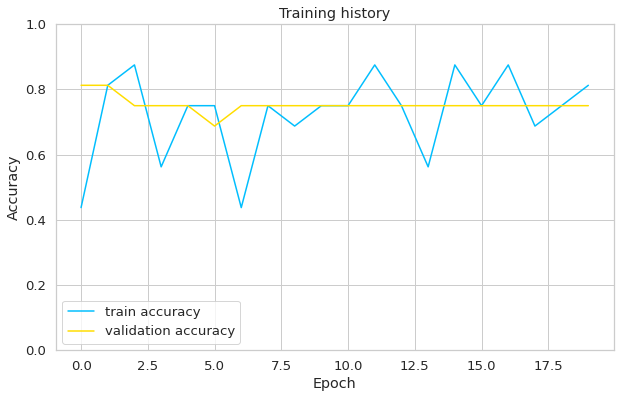

In [ ]:
plt.plot(acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### BERTweet

As the standard BERT for Sequence Classification does not manage to make useful predictions on the validation set, we try a different version. For that, we get BERTweet from the Huggingface page. 


> BERTweet is the first public large-scale language model pre-trained for English Tweets. BERTweet is trained based on the RoBERTa pre-training procedure. The corpus used to pre-train BERTweet consists of 850M English Tweets (16B word tokens ~ 80GB), containing 845M Tweets streamed from 01/2012 to 08/2019 and 5M Tweets related to the COVID-19 pandemic. The general architecture and experimental results of BERTweet can be found in our [paper](https://aclanthology.org/2020.emnlp-demos.2/).

As out data are sarcastic Tweets, we hope that this model might be able to better capture their characteristics.


#### Model

In [ ]:
class SarcasticBERTweet(nn.Module):
  
  def __init__(self, n_hidden):
    super().__init__()
    self.n_hidden = n_hidden

    self.bert = AutoModel.from_pretrained("vinai/bertweet-base")
    self.drop1 = nn.Dropout(p=0.2)
    self.linear1 = nn.Linear(self.bert.config.hidden_size, self.n_hidden)
    self.sigmoid1 = nn.Sigmoid()
    # self.drop2 = nn.Dropout(p=0.3)
    self.linear2 = nn.Linear(self.n_hidden, 1)
    self.sigmoid2 = nn.Sigmoid()

  def forward(self, input_ids, attention_mask):
    output = self.bert(
      input_ids=input_ids, 
      attention_mask=attention_mask
    )
    out = self.drop1(output['pooler_output'])
    out = self.linear1(out)
    out = self.sigmoid1(out)
    # out = self.drop2(out)
    out = self.linear2(out)
    out = self.sigmoid2(out)

    return out

In [ ]:
model = SarcasticBERTweet(256)
model.to(device)

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/517M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SarcasticBERTweet(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((7

#### Training

In [ ]:
EPOCHS = 10

# define loss, optimizer, and scheduler
loss_fn = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
total_steps = len(train_dataloader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [ ]:
# define train run

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples, threshold=0.5):
  # set training modes
  model = model.train()

  # initiate tracking variables
  losses = []
  correct_predictions = 0
  
  # loop over data
  for (input_ids, attention_mask, labels) in data_loader:
     
    # send inputs to GPU
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    targets = labels.float().to(device)

    # aplly model
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    outputs = outputs.flatten()

    # make predictions and calculate the loss
    preds = (outputs>threshold).float()
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    # backpropagation
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# define evaluation run

def eval_model(model, data_loader, loss_fn, device, n_examples, threshold=0.5):
  # set evaluation mode
  model = model.eval()

  # initiate tracking variables
  losses = []
  correct_predictions = 0

  # loop over validation data
  with torch.no_grad():
    for (input_ids, attention_mask, labels) in data_loader:
      
      # send inputs to GPU
      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      targets = labels.float().to(device)
      
      # apply model
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      outputs = outputs.flatten()

      # make predictions and calculate the loss
      preds = (outputs>threshold).float()
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
# train the model

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  # call train run
  train_acc, train_loss = train_epoch(
    model,
    train_dataloader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(train_data)
  )

  # report loss and accuracy
  print(f'Train loss {train_loss} accuracy {train_acc}')

  # call eval run
  val_acc, val_loss = eval_model(
    model,
    validation_dataloader,
    loss_fn, 
    device, 
    len(validation_data)
  )

  # report loss and accuracy
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  # update history
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  # save best model
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.5788145896333915 accuracy 0.7354709418837675
Val   loss 0.5737423449754715 accuracy 0.7410071942446044

Epoch 2/10
----------
Train loss 0.5532918688960564 accuracy 0.7611222444889779
Val   loss 0.5684511429733701 accuracy 0.7410071942446044

Epoch 3/10
----------
Train loss 0.551880575907536 accuracy 0.7611222444889779
Val   loss 0.5742726392216153 accuracy 0.7410071942446044

Epoch 4/10
----------
Train loss 0.5507516836126646 accuracy 0.7611222444889779
Val   loss 0.5706530312697092 accuracy 0.7410071942446044

Epoch 5/10
----------
Train loss 0.5479435376249827 accuracy 0.7611222444889779
Val   loss 0.5763416066765785 accuracy 0.7410071942446044

Epoch 6/10
----------
Train loss 0.5440523861310421 accuracy 0.7611222444889779
Val   loss 0.5669677919811673 accuracy 0.7410071942446044

Epoch 7/10
----------
Train loss 0.4956569917117938 accuracy 0.7727454909819639
Val   loss 0.6210456738869349 accuracy 0.6690647482014389

Epoch 8/10
----------
Train 

In [ ]:
acc = [h.cpu().numpy() for h in history['train_acc']]
val_acc = [h.cpu().numpy() for h in history['val_acc']]

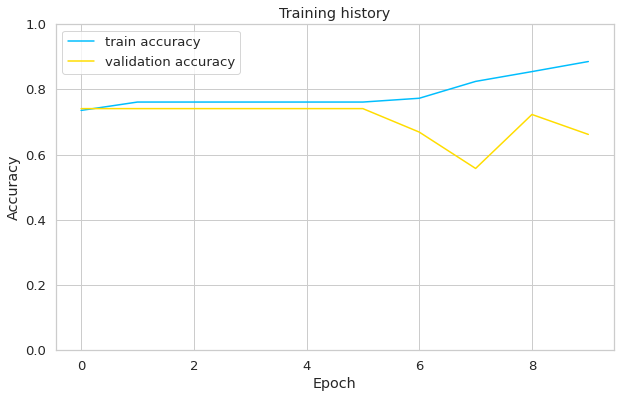

In [ ]:
plt.plot(acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

#### Test model

In [ ]:
test_acc, test_loss = eval_model(
    model,
    test_dataloader,
    loss_fn, 
    device, 
    len(test_data)
  )

print(f'The model achieved {np.round(test_acc.cpu()*100, 2)}% accuracy on the test set. A naive predictor that would only predict non-sarcastic would achieve: {np.round(100*(1-test_labels.sum()/len(test_labels)).numpy(), 2)}%.')

The model achieved 64.55% accuracy on the test set. A naive predictor that would only predict non-sarcastic would achieve: 71.33%.


# Conclusion

The task was to classify Tweets as sarcastic or non-sarcastic. We tried several baseline models and two versions of BERT. We tested the second one (BERTweet, fine-tuned on english Tweets) on our test set:

|Model|Test accuracy|
|--|--|
|Naive Classifier (all 0)|71.33%|
|BERTweet|64.55%|

None of our models was able to make any meaningful predictions in the validation or test set. Mainly our classifiers predicted all the samples to be non-sarcastic. This means they were not able to learn any useful features from the training data that would make it possible to identify sarcastic Tweets. 

To test if there is something wrong with our models, we applied them to another dataset with a simpler classification task. There, the task consisted of identifying tweets related to catastrophe ([source](https://www.kaggle.com/competitions/nlp-getting-started)). For this task, the same two BERT models managed to learn the pattern and performed well. 

In the end, we can conclude that the models we implemented are not able to properly learn how to solve the task of sarcastic classification. We might be able to improve our modeling if we had more training data or we could implement a model that is more based on theory and understanding of the tasks’ features. An example of this can be found in Shani et al, 2021.



<center>
<i><b>Fin</b></i>
</center>

# References

* Chen Shani, Nadav Borenstein, and Dafna Shahaf. "How Did This Get Funded?! Automatically Identifying Quirky Scientific Achievements". Proceedings of the 59th Annual Meeting of the Association for Computational Linguistics and the 11th International Joint Conference on Natural Language Processing (Volume 1: Long Papers) (2021)

* Mao, Jihang and Wanli Liu. “A BERT-based Approach for Automatic Humor Detection and Scoring.” IberLEF@SEPLN (2019)

* Annamoradnejad, Issa. “ColBERT: Using BERT Sentence Embedding for Humor Detection.” ArXiv abs/2004.12765 (2020): n. pag.

* https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03

* Dat Quoc Nguyen, Thanh Vu, and Anh Tuan Nguyen. 2020. BERTweet: A pre-trained language model for English Tweets. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing: System Demonstrations, pages 9–14, Online. Association for Computational Linguistics.